In [1]:
%load_ext autotime

In [2]:
import os
from glob import glob

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('bmh')

from tqdm import tqdm_notebook

from piaa.utils import pipeline
from piaa.utils.postgres import get_cursor
from piaa.utils import helpers
from piaa.utils import plot
from pocs.utils.images import fits as fits_utils
from pocs.utils.images import crop_data

from piaa.utils.postgres import get_cursor
tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

time: 2.07 s


In [3]:
fields_dir = os.path.join(os.environ['PANDIR'], 'images', 'fields')

time: 876 µs


In [4]:
# base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/14d3bd/20180913T085704')
# base_dir = os.path.join(fields_dir, 'PAN001/Hd189733/ee04d1/20180913T085704')
base_dir = os.path.join(fields_dir, 'PAN012/Hd189733/358d0f/20180822T035809')
# base_dir = os.path.join(fields_dir, 'PAN001/Wasp50/ee04d1/20181215T050712')

base_dir

'/var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809'

time: 6.24 ms


In [5]:
# Get all the files that start with a time stamp (skip pointing files)
fits_files = sorted(glob(
    os.path.join(base_dir, '*2018*.fits')
), )
print("Found {} FITS files".format(len(fits_files)))

Found 128 FITS files
time: 3.09 ms


## Lookup point sources

Looking up the point sources invovles two steps, extracting detected sources from the image and matching those with a catalog.

> Note: This assumes the images have already been downloaded and plate-solved.  
> _todo(wtgee) add a link to a notebook that does that_

**Source Detection** For source extraction there are three methods available but the default is to use the well-known [`sextractor`](https://www.astromatic.net/software/sextractor) to  automatically detect sources according to certain configurable parameters. The [PIAA sextractor config](https://raw.githubusercontent.com/panoptes/PIAA/develop/resources/conf_files/sextractor/panoptes.sex) sets a photometric aperture of 6 pixels ($6 \times 10.3'' \approx 80''$) and a detection threshold of 1.5 sigmas. Further filtering of flags and basic SNR is done below.

**Catalog Matching** PANOPTES hosts a copy of the TESS Input Catalog (v6) against which the detected sources are matched. The detection uses the peak pixel value as reported by `sextractor` compared against the TICv6 using standard [astropy catalog matching](http://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs) techniques. Reported catalog separation is neglible, especially regarding the creationg of the stamps for the RGB pixel pattern (see below).

#### Lookup all files

Perform the same thing again but for all files. The resulting source catalog created from `sextractor` is saved for each image and reused in subsequent runs unless `force_new=True`.

Extract the observation time, the exposure time, and the airmass from the FITS headers.

The image observation time currently comes from the image file name, which is generated by the computer running the unit and is given in UTC. This is mainly due to a problem with the `DATE-OBS` header in the FITS files for POCS versions <0.6.2.

In [6]:
source_filename = os.path.join(base_dir, f'point-sources-detected.csv')

observation_sources = pipeline.lookup_sources_for_observation(
    fits_files=fits_files, 
    filename=source_filename, 
    cursor=tess_cursor, 
    force_new=False,
)
observation_sources['obstime'] = observation_sources.index
observation_sources.set_index('picid', inplace=True)

time: 861 ms


In [7]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 128 Sources: 1765
time: 7.01 ms


In [8]:
observation_sources.tail()

,ra,dec,x,y,x_image,y_image,background,flux_best,fluxerr_best,mag_best,...,fwhm_image,flags,tmag,vmag,catalog_sep_arcsec,exptime,airmass,file,picid.1,obstime
picid,,,,,,,,,,,,,,,,,,,,,
452180117,296.850163,23.928531,1774,2444,1774.0310,2444.0039,4056.512,29352.21,3828.608,13.8309,...,3.62,0,7.786,8.20100,8.140965,35.0,1.134706,20180822T074952.fits,452180117,2018-08-22 07:50:09.500
452310782,303.555914,28.689543,80,348,79.6854,348.6451,3025.272,222313.30,6904.409,11.6326,...,9.93,4,12.529,16.90900,19.849596,35.0,1.134706,20180822T074952.fits,452310782,2018-08-22 07:50:09.500
452366964,303.625735,24.844161,1435,287,1435.4688,287.4220,3346.204,63517.95,5275.852,12.9928,...,3.63,0,7.524,7.47000,5.038130,35.0,1.134706,20180822T074952.fits,452366964,2018-08-22 07:50:09.500
452456703,303.814196,25.590542,1171,236,1171.2488,235.3018,3353.259,278965.30,6937.791,11.3861,...,7.52,4,5.084,4.76925,8.386335,35.0,1.134706,20180822T074952.fits,452456703,2018-08-22 07:50:09.500
471012056,299.689405,19.493495,3328,1531,3328.0938,1531.2448,3630.823,710438.70,7655.326,10.3712,...,9.35,0,3.510,3.49408,5.141812,35.0,1.134706,20180822T074952.fits,471012056,2018-08-22 07:50:09.500


time: 33.8 ms


## Filter detected sources

The above sequence does basic source filtering via `sextractor` along with what can be matched in the TESS catalog. Below are a number of different ways to filter the frames and/or sources based on image quality, number of detections, etc.

The filtering for the `PAN012` HD189733 data set involves the steps below. At the bottom of the notebook are optional filter methods.

### Frame filtering

We can do some quick checks on the overall image sequence. here we look at the mean background as detected by `sextractor`. It's a rough metric but we can clearly see some frames where the background levels spike, indicating clouds in the region.

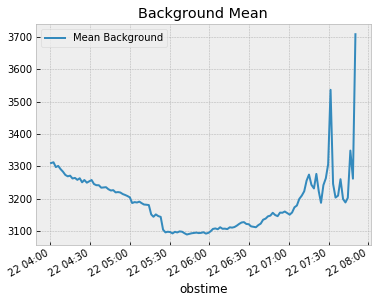

time: 347 ms


In [9]:
plt.figure(figsize=(6, 4.5))
observation_sources.groupby('obstime').background.mean().plot(label='Mean Background')
plt.title(f'Background Mean')
plt.legend()

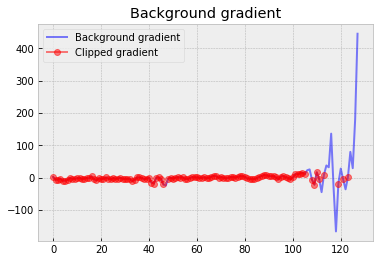

time: 359 ms


In [10]:
bkg_gradient = np.gradient(observation_sources.groupby('obstime').background.mean())

plt.plot(bkg_gradient, color='b', alpha=0.5, label='Background gradient')
plt.plot(sigma_clip(bkg_gradient), color='r', alpha=0.5, marker='o', label='Clipped gradient')

plt.title('Background gradient')
plt.legend()

#### Filter on background

We fit a 6th order polynomial to the background count and then filter the frames that deviate too far from this fit.

In [11]:
counts = observation_sources.groupby('obstime').count().file

x = np.arange(len(counts))
y = counts

poly = np.poly1d(np.polyfit(x, y, 6))

time: 55.8 ms


In [12]:
counts_mean, counts_med, counts_std = sigma_clipped_stats(counts - poly(x))

time: 10.5 ms


In [13]:
frame_mask = abs(counts - poly(x)) >= (3 * counts_std)
bad_frames = frame_mask.where(frame_mask).dropna().index.values

time: 3.04 ms


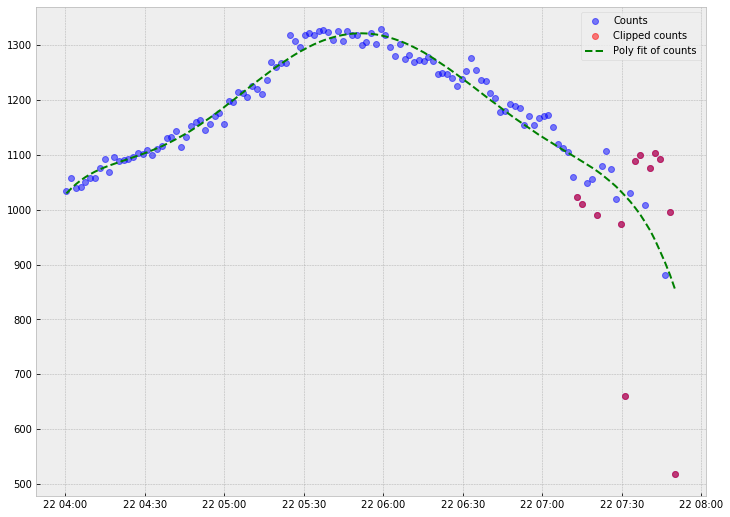

time: 481 ms


In [14]:
plt.figure(figsize=(12, 9))
plt.plot(counts, ls='', marker='o', c='b', alpha=0.5, label='Counts')
plt.plot(counts.index, np.ma.array(counts, mask=~frame_mask), ls='', marker='o', color='r', alpha=0.5, label='Clipped counts')
plt.plot(counts.index, poly(x), ls='--', label='Poly fit of counts', color='g')
plt.legend()

In [15]:
# Filter out the frames where where the number of sources is outside the std
observation_sources = observation_sources.loc[~observation_sources.obstime.isin(bad_frames)]

time: 16.2 ms


In [16]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 116 Sources: 1745
time: 5.75 ms


#### Filter sources by number of frames

Now that we have removed frames where there were a low number of detections (presumably from clouds) we now want to remove sources that don't appear in most of the frames.

In [17]:
frame_count = observation_sources.groupby('picid').count().file
min_frame_count = int(frame_count.max() * .98)

print(f'Total frames: {frame_count.max()} Min cutout: {min_frame_count}')

Total frames: 116 Min cutout: 113
time: 23.1 ms


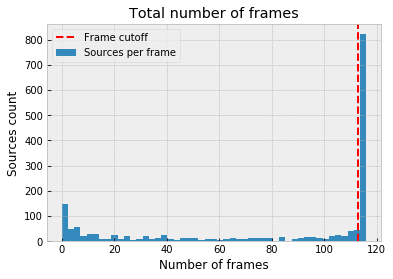

time: 422 ms


In [18]:
# Show a sample of the source count
plt.axvline(min_frame_count, ls='--', color='r', label='Frame cutoff')
frame_count.hist(bins=np.linspace(0, num_frames), label='Sources per frame')

plt.xlabel('Number of frames')
plt.ylabel('Sources count')

plt.title('Total number of frames')
plt.legend()

In [19]:
# Filter out the sources where the number of frames is less than min_frame_count
observation_sources = observation_sources.groupby('picid').filter(lambda grp: grp.count()['file'] >= min_frame_count)

time: 2.18 s


In [20]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 116 Sources: 838
time: 4.62 ms


### Source filtering

`sextractor` does basic thresholding and source detection per frame but here we filter sources based off the entire image sequence. The simplest filter is to get all the images with a certain SNR limit (default 10). A filter for source extractor flags can also be used.

> Note: There has been a manual selection of images (see above) for overall data quality. Some kind of image quality check (e.g. drifting zeropoint) could help automate this

In [21]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 116 Sources: 838
time: 4.89 ms


#### sextractor flags filter

Filter out anything with [SE flags](http://matilda.physics.ucdavis.edu/working/website/SEflags.html) of 4 or more. Note that this is leaving in some blended sources 

In [22]:
observation_sources = observation_sources.groupby('picid').filter(lambda grp: all(grp['flags'] < 4))

time: 470 ms


In [23]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 116 Sources: 725
time: 4.08 ms


#### FWHM Filter

We also want to get rid of the stars where `sextractor` reports a large FWHM. This could be refined but for now we do a simple cut.

In [24]:
fwhm_limit = 3

low_fwhm = lambda grp: (grp['fwhm_image']).mean() <= fwhm_limit

observation_sources = observation_sources.groupby('picid').filter(low_fwhm)

time: 329 ms


In [25]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 116 Sources: 213
time: 2.32 ms


##### SNR Filter

The SNR comes directly from `sextractor` in the form of `FLUX_AUTO / FLUXERR_AUTO`.

In [26]:
snr_limit = 5

high_snr = lambda grp: (grp['flux_best'] / grp['fluxerr_best']).mean() > snr_limit

observation_sources = observation_sources.groupby('picid').filter(high_snr)

time: 153 ms


In [27]:
num_sources = len(observation_sources.index.unique())
num_frames = len(set(observation_sources.file))
print(f"Frames: {num_frames} Sources: {num_sources}")

Frames: 116 Sources: 190
time: 2.62 ms


#### Look at x-y spread

In [28]:
# observation_sources.set_index('picid', append=True, inplace=True)
delta_x = observation_sources.groupby('picid').apply(lambda grp: grp.x_image - np.median(grp.x_image))
delta_y = observation_sources.groupby('picid').apply(lambda grp: grp.y_image - np.median(grp.y_image))

time: 218 ms


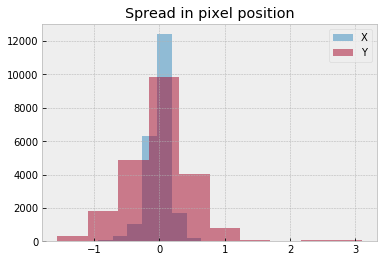

time: 301 ms


In [29]:
delta_x.hist(alpha=0.5, label='X')

delta_y.hist(alpha=0.5, label='Y')

plt.title('Spread in pixel position')
plt.legend()

#### Pixel drift

Look at the picids that have a large drift in either the x or y pixel direction

**NB: These are not filtered yet. The large drift mostly occurs in one or two frames per source and those individual frames tend to get filtered during sigma clipping of the target/reference as they have a large residual compared to the rest of the frames.**

In [30]:
max_pixel_drift = 5

time: 655 µs


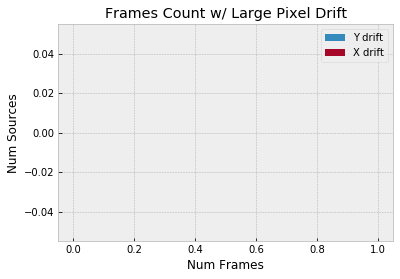

time: 311 ms


In [31]:
# Look at those with large drift 
delta_y.loc[abs(delta_y > max_pixel_drift)].groupby('picid').count().hist(label='Y drift')
delta_y.loc[abs(delta_x > max_pixel_drift)].groupby('picid').count().hist(label='X drift')

plt.xlabel('Num Frames')
plt.ylabel('Num Sources')

plt.title('Frames Count w/ Large Pixel Drift')
plt.legend()

#### Output filtered source detections

We save this filtered file to be used for subsequent processing.

In [32]:
filtered_filename = os.path.join(base_dir, f'point-sources-filtered.csv.bz2')

time: 731 µs


In [33]:
observation_sources.to_csv(filtered_filename, compression='bz2')

time: 1.48 s


In [34]:
ls -lh $filtered_filename

-rw-r--r-- 1 wtylergee wtylergee 1.5M Dec 24 05:35 /var/panoptes/images/fields/PAN012/Hd189733/358d0f/20180822T035809/point-sources-filtered.csv.bz2
time: 131 ms
